# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud, STOPWORDS
import xgboost as xgb

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more g

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and"ko-"  is "child of" or of "derived from".) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.
What can I say..

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb pan bread a Portuguese loan word and quot ko quot is quot child of quot or of quot derived from quot Panko are used for katsudon tonkatsu or cutlets served on rice or in soups The cutlets pounded chicken or pork are coated with these light and crispy crumbs and fried They are not gritty and dense like regular crumbs They are very nice on deep fried shrimps and decorative for a more gourmet touch 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
prepr_rev = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    prepr_rev.append(sentance.strip())
    

100%|██████████| 160176/160176 [01:24<00:00, 1895.29it/s]


In [23]:
prepr_rev[1500]

'japanese version breadcrumb pan bread portuguese loan word ko child derived panko used katsudon tonkatsu cutlets served rice soups cutlets pounded chicken pork coated light crispy crumbs fried not gritty dense like regular crumbs nice deep fried shrimps decorative gourmet touch'

In [24]:
print(len(prepr_rev))
final.shape

160176


(160176, 10)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.
preprocessed_summary = []
# tqdm is for printing the status bar
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary) # remove urls from text python: https://stackoverflow.com/a/40823105/4084039 
    summary = BeautifulSoup(summary, 'lxml').get_text() # https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip() #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
    summary = re.sub('[^A-Za-z]+', ' ', summary) #remove spacial character: https://stackoverflow.com/a/5843547/4084039
    # https://gist.github.com/sebleier/554280
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())

 58%|█████▊    | 92317/160176 [00:31<00:22, 2966.05it/s]/Volumes/Saida/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 160176/160176 [00:54<00:00, 2930.68it/s]


In [26]:
prepr_rev = [i + ' ' + j for i, j in zip(prepr_rev,preprocessed_summary)] 
print(prepr_rev[1500])

japanese version breadcrumb pan bread portuguese loan word ko child derived panko used katsudon tonkatsu cutlets served rice soups cutlets pounded chicken pork coated light crispy crumbs fried not gritty dense like regular crumbs nice deep fried shrimps decorative gourmet touch essential tonkatsu etc


In [27]:
final ['CleanText']= prepr_rev
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,1,1325721600,A classic,I remembered this book from my childhood and g...,remembered book childhood got kids good rememb...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138686,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,entertaining rhyming story cleaver catchy illu...
138685,150503,0006641040,A3R5XMPFU8YZ4D,"Her Royal Motherliness ""Nana""",1,1,1,1233964800,so fun to read,This is my grand daughter's and my favorite bo...,grand daughter favorite book read loves rhythm...


In [28]:
##Sorting data for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


final = time_sorted_data.take(np.random.permutation(len(final))[:100000])
print(final.shape)
final.head()

(100000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
8906,9754,B000KFXEYE,A37HQ91XODAEPT,JGood,1,1,1,1322611200,amazing!,i found the packets at walmart for 57 cents i ...,found packets walmart cents believe went back ...
28063,30606,B004538TME,A18TD63LUDC3P2,"R. Holland ""Chatmandu""",0,0,1,1347148800,Best of the K-cups,I find the Folgers Lively Colombian K-cup the ...,find folgers lively colombian k cup best mediu...
5236,5676,B000H23YC2,A37H9RV4TNKLAH,Bill,2,2,1,1205798400,Great Deal,"Very good taste and a good price, no sales tax...",good taste good price no sales tax no shipping...
193647,209951,B001DDBL2Y,A2U8KKXRXZ2FVZ,cathybb,1,1,1,1324080000,Wonderful Truffle Flavor,"I had used this product before, mostly for sa...",used product mostly salad dressing unable get ...
27388,29870,B0045CTYNI,AM3VWXDW4YV96,Ali,0,0,1,1295913600,Delicious!,"I first tried these at a friend's house, and f...",first tried friend house day forward hooked li...


# [4] Featurization

## [4.1] BAG OF WORDS

In [29]:
X = np.array(prepr_rev)
y = np.array(final['Score'])

In [30]:
from sklearn.model_selection import train_test_split
#splitting data into Train, C.V and Test
X_train, X_test, y_train, y_test = train_test_split(final ['CleanText'], final['Score'], test_size=0.33) 
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33)
print("Train:",X_train.shape,y_train.shape)
print("CV:",X_cv.shape,y_cv.shape)
print("Test:",X_test.shape,y_test.shape)

Train: (44890,) (44890,)
CV: (22110,) (22110,)
Test: (33000,) (33000,)


In [90]:
#BoW
 
vectorizer = CountVectorizer(min_df=10, max_features=500) 
vectorizer.fit(X_train)
#vectorizer.fit(X_train) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test) 
print("After vectorizations")
print(X_train_bow.shape, y_train.shape) 
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape) 

After vectorizations
(44890, 500) (44890,)
(22110, 500) (22110,)
(33000, 500) (33000,)


## [4.2] Bi-Grams and n-Grams.

In [32]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000) 
vectorizer.fit(X_train)
#vectorizer.fit(X_train) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test) 
print("After vectorizations")
print(X_train_bow.shape, y_train.shape) 
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape) 
 
print("the number of unique words including both unigrams and bigrams ", X_train_bow.get_shape()[1])

After vectorizations
(44890, 5000) (44890,)
(22110, 5000) (22110,)
(33000, 5000) (33000,)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [91]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect.fit(X_train)
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test) 
print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape) 
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape) 
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)


After vectorizations
(44890, 500) (44890,)
(22110, 500) (22110,)
(33000, 500) (33000,)
some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almost', 'also', 'alternative', 'although']


## [4.4] Word2Vec

In [34]:
# Train your own Word2Vec model using your own text corpus
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_test text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
    
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

[('fantastic', 0.810080349445343), ('excellent', 0.809391975402832), ('good', 0.807015061378479), ('awesome', 0.8037440776824951), ('wonderful', 0.7604235410690308), ('terrific', 0.7550438642501831), ('perfect', 0.7015278339385986), ('nice', 0.682224452495575), ('amazing', 0.6674833297729492), ('fabulous', 0.6632910966873169)]
[('greatest', 0.7800548672676086), ('best', 0.6784257888793945), ('coolest', 0.6488667726516724), ('nastiest', 0.6442927122116089), ('disgusting', 0.6270002126693726), ('tasted', 0.6215249300003052), ('horrible', 0.6196838617324829), ('shameful', 0.6194093823432922), ('terrible', 0.6028367280960083), ('closest', 0.5882868766784668)]
number of words that occured minimum 5 times  13466


In [35]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13466
sample words  ['wondeful', 'product', 'shipping', 'fast', 'packing', 'perfect', 'love', 'matzo', 'ball', 'soup', 'kinds', 'jewish', 'cuisine', 'not', 'even', 'definitely', 'buy', 'following', 'directions', 'get', 'light', 'fluffy', 'flavorful', 'results', 'addictive', 'mix', 'cookies', 'great', 'flavor', 'no', 'aftertaste', 'detect', 'find', 'gritty', 'quite', 'crispy', 'like', 'think', 'good', 'regular', 'sugar', 'cookie', 'ever', 'non', 'gf', 'friends', 'agree', 'wonderful', 'daughter', 'major']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

In [36]:
i=0
sent_of_test_cv=[]
for sentance in X_cv:
    sent_of_test_cv.append(sentance.split())

In [37]:
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sent_of_test_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 22110/22110 [01:13<00:00, 302.63it/s]

(22110, 50)
[ 0.06498721  0.79612739  0.26068903  0.20172371  0.37437537  0.04439201
  0.21733876 -0.54119455 -0.22884366  0.74916206 -0.06431492 -0.07987306
  1.11170487 -0.31706246 -0.13208098  1.00752133 -0.15806267 -0.23693262
  0.13166478  0.1162586  -1.00791549 -0.7041703  -0.33810824 -0.09102126
 -0.13344762  0.44736069  0.59063813 -0.32998469  0.15480058 -0.39336889
  0.03248305  0.02316775 -0.2707646  -1.34723554  0.15182858  0.15244402
 -0.41337191 -0.4309975  -0.09680952  0.07562984 -0.4351498  -0.1212412
  0.25109532 -1.22230623 -0.12066191  0.08960353  0.12554569  0.06179929
  0.20668169 -0.1875396 ]


#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
# compute average word2vec for X_test .
test_vectors = []; 
for sent in tqdm(sent_of_test):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)  
    
test_vectors = np.array(test_vectors)

print(test_vectors.shape)
print(test_vectors[0])  


100%|██████████| 33000/33000 [01:50<00:00, 297.40it/s]

(33000, 50)
[-0.23268548  0.35172849  0.19188095 -0.08529245  0.40004842 -0.22606502
 -0.1418867  -0.70343915  0.06465353  0.21826539 -0.51531387 -0.18519199
  0.43089552  0.6235833  -0.02229553  0.35233837  0.00090884  0.24472451
  0.10192246  0.48772127  0.13919623 -0.3738773  -0.33740767 -0.04211258
  0.04843662 -0.56999221  0.08535804 -0.04759118  0.83089965 -0.38167918
 -0.56302446  0.1117191   0.26977195 -0.82601625  0.14647374  0.6241476
 -0.07788345  0.02959642 -0.45181998  0.25285222 -0.34787317 -0.00980091
 -0.24544531 -0.40470703 -0.09558729  0.61882325  0.3640449   0.71307979
  0.84713797 -0.46049427]


In [39]:
# compute average word2vec for X_train .
train_vectors = []; 
for sent in tqdm(sent_of_train):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
train_vectors = np.array(train_vectors)

print(train_vectors.shape)
print(train_vectors[0])

100%|██████████| 44890/44890 [02:29<00:00, 299.80it/s]


(44890, 50)
[-0.31910905  0.27935335  0.32598865  0.31491613  0.03758824 -0.50678713
 -0.08773003  0.05044405  0.473852    0.25108572 -0.59380067 -0.12560968
  0.11229882 -0.15477959 -0.32888119  0.28322356 -0.18378382  0.45001692
  0.02249543  0.09882321  0.14622723 -0.0857125  -0.33752663  0.0719414
  0.08242424 -0.6205999   0.18840833 -0.59825554  0.30026937 -0.56249011
 -0.16023349 -0.3777474  -0.1664964  -0.29557947 -0.09134184  0.35897609
 -0.10299782 -0.26266114 -0.1364854   0.12358404 -0.62402336 -0.02887721
 -0.19590467 -0.31029066  0.13540766  0.37399933  0.0732796   0.38830157
  0.68563001 -0.20348505]


#### [4.4.1.2] TFIDF weighted W2v

In [40]:
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in tqdm(sent_of_test): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    
tfidf_test_vectors = np.array(tfidf_test_vectors)
print(tfidf_test_vectors.shape)
print(tfidf_test_vectors[0])

100%|██████████| 33000/33000 [25:01<00:00, 15.81it/s]  


(33000, 50)
[-0.20276099  0.30447506  0.17174864 -0.07191119  0.45382269 -0.23950305
 -0.05583434 -0.75551109 -0.06018428  0.29591458 -0.44489194 -0.20126017
  0.40175292  0.55755182  0.04899497  0.41795232  0.0594283   0.24494245
  0.18458354  0.42108216  0.19986278 -0.30134463 -0.2933384  -0.10489484
 -0.03140518 -0.50438341  0.11721851  0.012807    0.76551866 -0.34425957
 -0.50673818  0.24516161  0.23638625 -0.85461346  0.07109969  0.66123028
  0.03299534  0.06650675 -0.47469753  0.29820355 -0.35776846 -0.17524998
 -0.15472057 -0.18534192 -0.1779434   0.6307442   0.3993236   0.60414246
  0.89752377 -0.50729357]


In [41]:
# TF-IDF weighted Word2Vec
# compute TFIDF Weighted Word2Vec for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in tqdm(sent_of_train): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)

tfidf_train_vectors = np.array(tfidf_train_vectors)
print(tfidf_train_vectors.shape)
print(tfidf_train_vectors[0])

100%|██████████| 44890/44890 [32:10<00:00, 23.26it/s]  


(44890, 50)
[-2.56802447e-01  3.14070048e-01  3.45627246e-01  3.68462719e-01
  2.25948723e-01 -3.56279106e-01 -2.48266758e-01  4.09600936e-02
  3.34919675e-01 -3.18066606e-04 -4.57560561e-01 -1.52397220e-01
  1.34887097e-01 -1.75561692e-01 -7.61514339e-03  6.08032479e-02
  1.09382645e-01  3.84822059e-01 -9.09374002e-02  4.70495199e-02
  2.06612782e-01 -4.69003473e-02 -1.49749163e-01  2.17264960e-02
  3.21512336e-02 -4.54173497e-01  2.87840300e-01 -3.65833184e-01
  1.92036222e-01 -6.48131327e-01 -1.28079410e-01 -3.66436702e-01
 -8.58847057e-02 -2.22805358e-01  7.90022147e-02  2.20167321e-01
 -2.76063352e-01 -2.74922634e-01 -8.23223315e-02  6.72367611e-03
 -4.66591485e-01 -2.47916430e-02 -2.21355611e-02 -1.00546210e-01
  5.43662395e-02  7.32211717e-02  5.50127946e-02  2.03007993e-01
  5.03268518e-01 -2.65069047e-01]


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [42]:
# Please write all the code with proper documentation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import GridSearchCV

def all_rf(X_train,y_train,X_cv):
    estimator = [5, 10, 50, 100, 200, 500, 1000]
    depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    hyper_param = {'n_estimators':estimator, 'max_depth':depth}
    
    clf = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'),hyper_param, verbose=1,scoring='roc_auc',n_jobs=-1,pre_dispatch=2)
    clf.fit(X_train_bow,y_train)
    opt_estimator, opt_depth = clf.best_params_.get('n_estimators'), clf.best_params_.get('max_depth')
    
    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']
    
    df_heatmap = pd. DataFrame(train_auc.reshape(len(estimator), len(depth)), index=estimator, columns=depth )
    fig = plt. figure(figsize=(16,5))
    heatmap = sns. heatmap(df_heatmap, annot=True, fmt='.4g')
    plt. title("Train Data", size=24)
    plt. xlabel('Depth' , size=18)
    plt. ylabel('Estimator' , size=18)
    plt. show()
    
    df_heatmap = pd. DataFrame(cv_auc.reshape(len(estimator), len(depth)), index=estimator, columns=depth )
    fig = plt. figure(figsize=(16,5))
    heatmap = sns. heatmap(df_heatmap, annot=True, fmt='.4g')
    plt. title("CV Data", size=24)
    plt. xlabel('Depth' , size=18)
    plt. ylabel('Estimator' , size=18)
    plt. show()
    
    
    print("Max depth is = ", opt_depth , " Optimal value of n_estimator :", opt_estimator)
    
    #Cv auc scores 
    print("--------------------------")
    print("Cv auc scores")
    print(cv_auc)
    print("Maximun Auc value :",max(cv_auc))
    
    #test data
    
    
    clf =RandomForestClassifier(max_depth=opt_depth, n_estimators=opt_estimator,class_weight = 'balanced')
    clf.fit(X_train_bow,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train_bow)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_bow)[:,1])                                             
                                                 
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.legend()
    plt.xlabel("FBR")
    plt.ylabel("TBR")
    plt.title("Train and Test Data")
    plt.show()
     
     
     #Confusion Matrix
    
    print("Train confusion matrix") 
    print(confusion_matrix(y_train, clf.predict(X_train_bow))) 
    print("Test confusion matrix")
    print(confusion_matrix(y_test, clf.predict(X_test_bow)))
    
 
    cm = confusion_matrix(y_train, clf.predict(X_train_bow))
    cm = confusion_matrix(y_test, clf.predict(X_test_bow))
    tn, fp, fn, tp = cm.ravel()
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# Code for drawing seaborn heatmaps
    class_names = ['0','1']
    df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
    fig = plt.figure(figsize=(5,3))
    heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('True label',size=18)
    plt.xlabel('Predict label',size=18)
    plt.title("Confusion Matrix\n",size=24)
    plt.show()

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:  8.8min finished


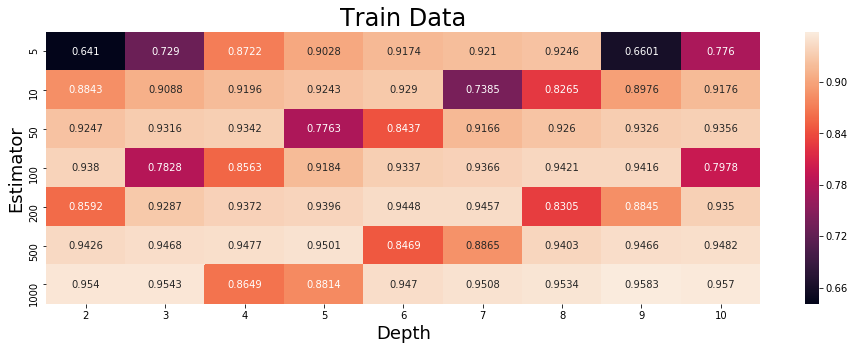

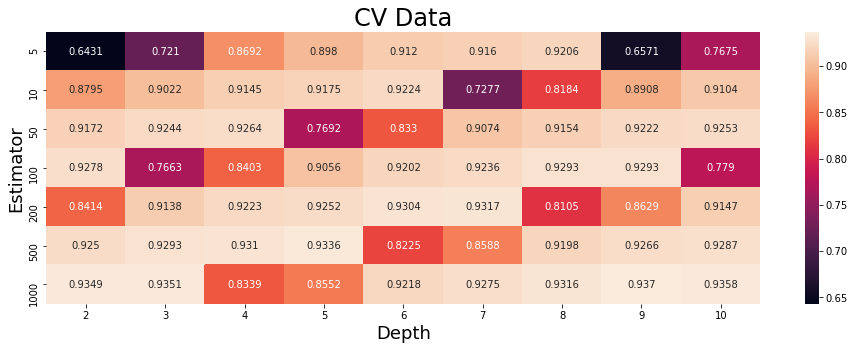

Max depth is =  10  Optimal value of n_estimator : 500
--------------------------
Cv auc scores
[0.64306296 0.72102825 0.86920008 0.89802974 0.9120104  0.91602503
 0.92063108 0.65714552 0.76750971 0.87950475 0.90215797 0.91453028
 0.91752454 0.9223938  0.72773727 0.81841925 0.89082506 0.91043621
 0.91717023 0.92437598 0.92642365 0.769206   0.83301082 0.90742643
 0.91544689 0.9222215  0.92528527 0.92780948 0.76631319 0.84030969
 0.90563715 0.92023849 0.92359432 0.92926564 0.92931172 0.77896497
 0.84138597 0.9137808  0.92225997 0.92519063 0.93043919 0.93167255
 0.8104872  0.8629247  0.91466523 0.92501138 0.92932048 0.93101859
 0.93364099 0.82246652 0.85878783 0.91982683 0.92659023 0.9286682
 0.93488273 0.93512712 0.83388712 0.85519033 0.92184951 0.92747775
 0.93160392 0.93700986 0.93575626]
Maximun Auc value : 0.9370098612086585


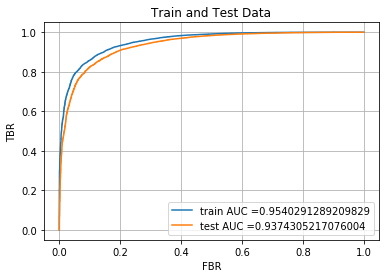

Train confusion matrix
[[ 6095  1101]
 [ 3505 34189]]
Test confusion matrix
[[ 4238   958]
 [ 2830 24974]]


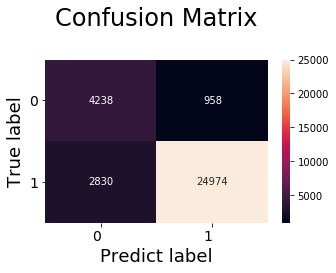

In [75]:
all_rf(X_train_bow,y_train,X_cv_bow)

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

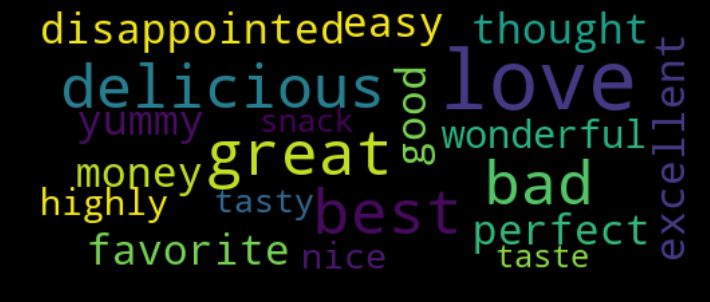

In [92]:
# Please write all the code with proper documentation
clf = RandomForestClassifier(max_depth= 10, n_estimators=500,class_weight='balanced')
clf.fit(X_train_bow,y_train)

feat = clf.feature_importances_
index=np.argsort(feat)
index_rev=index[::-1]
names=vectorizer.get_feature_names()
index_rev=index_rev[:30]

text=" "
for i in range(30):
    text = text + " " + names[index_rev[i]]   
wordcloud = WordCloud(width=500, height=200, max_words=20).generate(text) 
   
plt.figure(figsize=(12,12),facecolor='k' ) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show() 

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:  8.2min finished


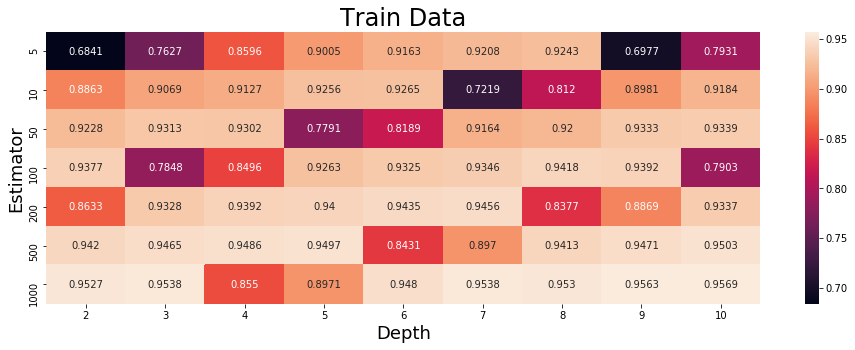

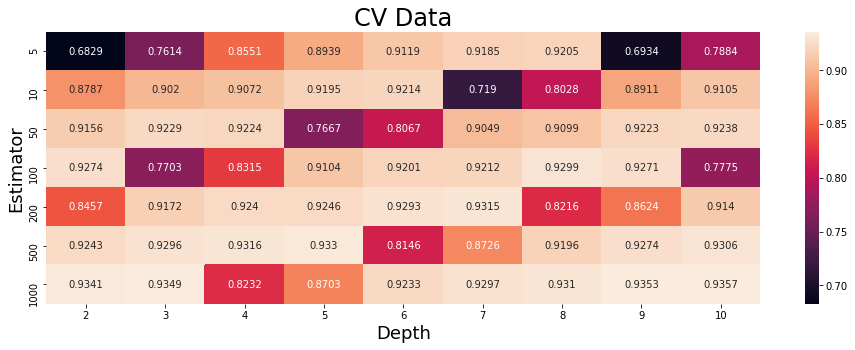

Max depth is =  10  Optimal value of n_estimator : 1000
--------------------------
Cv auc scores
[0.68286098 0.76142709 0.85507018 0.89394812 0.91190165 0.91851608
 0.92046121 0.6933842  0.78840661 0.87868933 0.90204536 0.90723438
 0.91946424 0.92141544 0.71899265 0.80277441 0.89111961 0.91050469
 0.91563363 0.92294541 0.92237332 0.7667209  0.80674262 0.90486909
 0.90992739 0.92232706 0.92381545 0.92744061 0.77026432 0.8315178
 0.9103639  0.92011372 0.92122408 0.9299138  0.92712863 0.77752776
 0.84567828 0.91723242 0.92398086 0.92462787 0.92933979 0.93153405
 0.82155301 0.86237955 0.91395101 0.92428194 0.92956058 0.93155128
 0.93303728 0.81462124 0.87256431 0.91960882 0.92735267 0.93056571
 0.93407258 0.93487938 0.82317334 0.87032882 0.9232574  0.92967838
 0.93098179 0.93528378 0.93574109]
Maximun Auc value : 0.9357410930140528


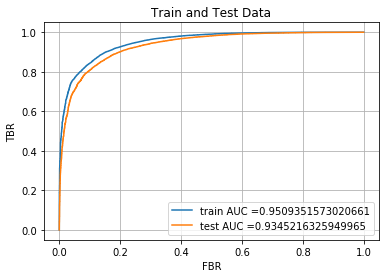

Train confusion matrix
[[ 6097  1099]
 [ 3781 33913]]
Test confusion matrix
[[ 4253   943]
 [ 3065 24739]]


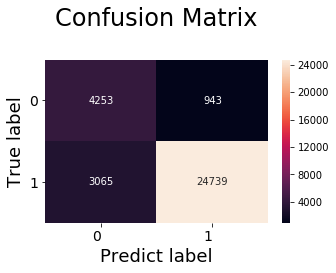

In [56]:
# Please write all the code with proper documentation
all_rf(X_train_tfidf,y_train,X_cv_tfidf)

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

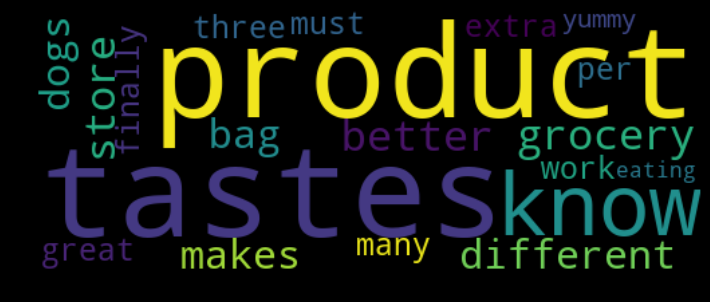

In [95]:
# Please write all the code with proper documentation
clf = RandomForestClassifier(max_depth= 10, n_estimators=1000,class_weight='balanced')
clf.fit(X_train_bow,y_train)

feat = clf.feature_importances_
index=np.argsort(feat)
index_rev=index[::-1]
names=tf_idf_vect.get_feature_names()
index_rev=index_rev[:30]

text=" "
for i in range(30):
    text = text + " " + names[index_rev[i]]   
wordcloud = WordCloud(width=500, height=200, max_words=20).generate(text) 
   
plt.figure(figsize=(12,12),facecolor='k' ) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show() 

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:  8.4min finished


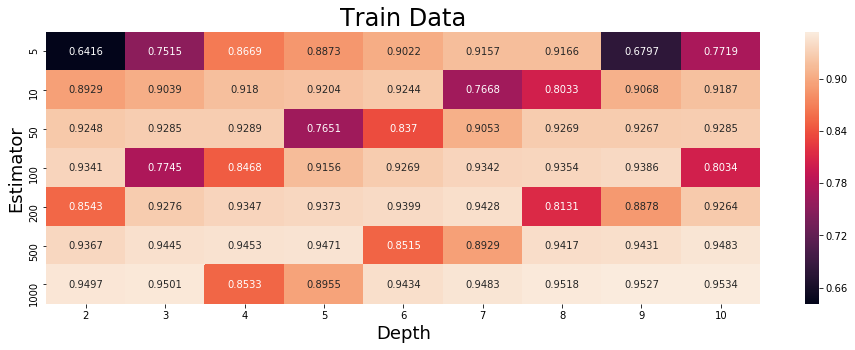

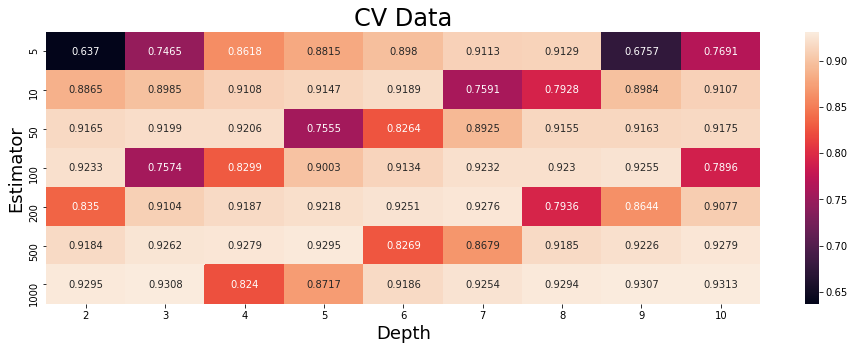

Max depth is =  10  Optimal value of n_estimator : 1000
--------------------------
Cv auc scores
[0.63703039 0.74651413 0.86179223 0.88154708 0.89798775 0.91127442
 0.91287378 0.67574295 0.7690975  0.88649984 0.89850633 0.91082222
 0.91473831 0.91894544 0.75908234 0.79277805 0.89843867 0.91069509
 0.91649076 0.91991837 0.92055706 0.75554251 0.82636891 0.89245141
 0.91545298 0.91628779 0.91748673 0.92325233 0.75737614 0.82990468
 0.90026087 0.91338176 0.92316353 0.92300582 0.92546764 0.78961935
 0.83504439 0.91041772 0.91866592 0.92181968 0.92510129 0.9276339
 0.79357003 0.86439589 0.90770235 0.91836227 0.92618697 0.92786057
 0.92946811 0.82691943 0.86789117 0.91852106 0.92263135 0.927867
 0.92951355 0.93078788 0.82398661 0.87171193 0.91857509 0.92535562
 0.92944238 0.93068038 0.93132632]
Maximun Auc value : 0.9313263198173527


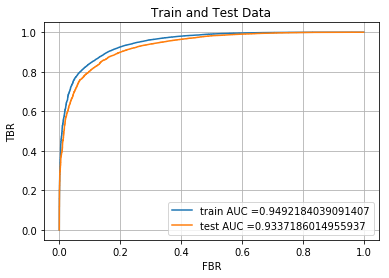

Train confusion matrix
[[ 6105  1138]
 [ 3841 33806]]
Test confusion matrix
[[ 4199   927]
 [ 3194 24680]]


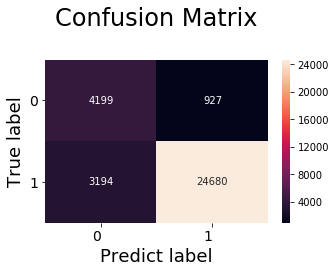

In [52]:
# Please write all the code with proper documentation
all_rf(train_vectors, y_train, X_cv)

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:  7.6min finished


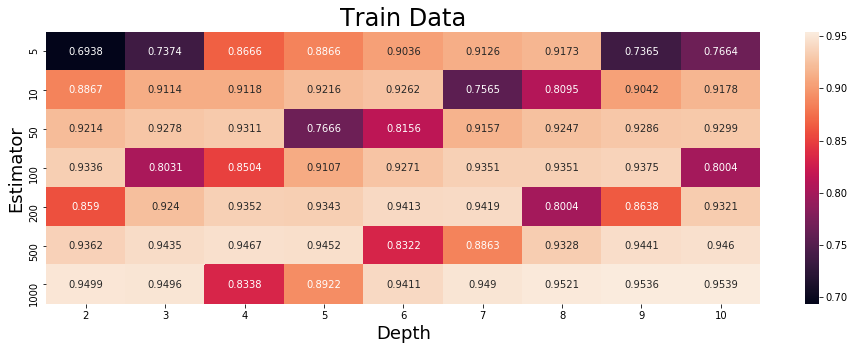

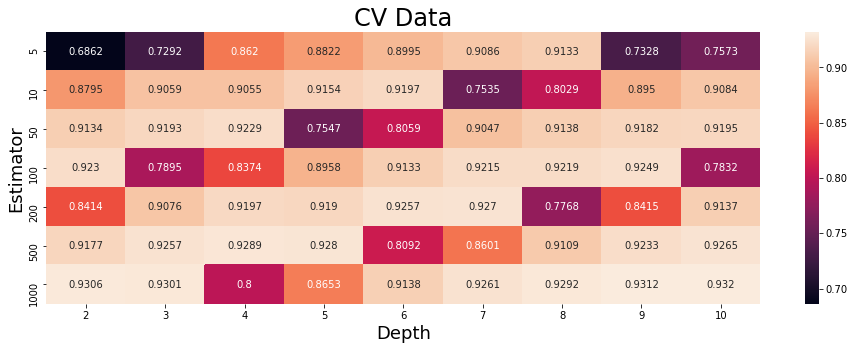

Max depth is =  10  Optimal value of n_estimator : 1000
--------------------------
Cv auc scores
[0.68620372 0.72915319 0.86195446 0.88215405 0.89946394 0.90860334
 0.91330617 0.73284026 0.75726952 0.8795419  0.90593102 0.90554532
 0.91540799 0.91972881 0.75351917 0.80290852 0.89500879 0.908375
 0.91335315 0.91928679 0.92286237 0.75470466 0.80590061 0.90471957
 0.91375045 0.91821072 0.91953689 0.92299218 0.78950238 0.83735446
 0.89582702 0.91326677 0.92148385 0.92191276 0.92489085 0.78316794
 0.8413537  0.90763394 0.91970834 0.91903725 0.92567512 0.92704196
 0.77677186 0.84151943 0.91369072 0.91774216 0.92573142 0.92890646
 0.92801267 0.80922807 0.86006371 0.91086335 0.92334284 0.92650346
 0.93058647 0.93007308 0.80001676 0.8653337  0.91384649 0.92606046
 0.92917037 0.93116979 0.93202383]
Maximun Auc value : 0.9320238272698838


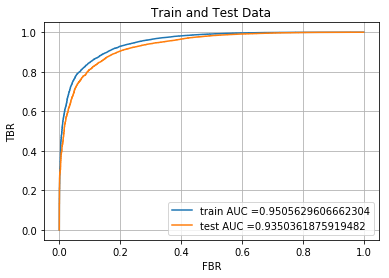

Train confusion matrix
[[ 6096  1147]
 [ 3751 33896]]
Test confusion matrix
[[ 4226   900]
 [ 3075 24799]]


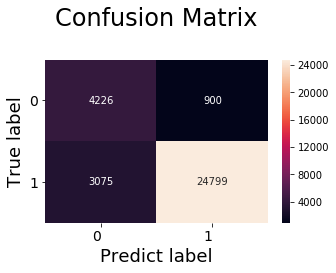

In [53]:
# Please write all the code with proper documentation
all_rf(tfidf_train_vectors,y_train,X_cv)

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [66]:
# Please write all the code with proper documentation

def all_xg(X_train,y_train,X_cv):
    
    estimator = [5, 10, 50, 100, 200, 500, 1000]
    depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    param = {'n_estimators':estimator, 'max_depth':depth}
    
    clf = GridSearchCV(xgb.XGBClassifier(booster='gbtree',class_weight = 'balanced'),param,verbose=1,scoring='roc_auc',n_jobs=-1,pre_dispatch=2)
    clf.fit(X_train_bow,y_train)
    opt_estimator, opt_depth = clf.best_params_.get('n_estimators'), clf.best_params_.get('max_depth')
    
    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']
    
    df_heatmap = pd. DataFrame(train_auc.reshape(len(estimator), len(depth)), index=estimator, columns=depth )
    fig = plt. figure(figsize=(16,5))
    heatmap = sns. heatmap(df_heatmap, annot=True, fmt='.4g')
    plt. title("Train Data", size=24)
    plt. xlabel('Depth' , size=18)
    plt. ylabel('Estimator' , size=18)
    plt. show()
    
    df_heatmap = pd. DataFrame(cv_auc.reshape(len(estimator), len(depth)), index=estimator, columns=depth )
    fig = plt. figure(figsize=(16,5))
    heatmap = sns. heatmap(df_heatmap, annot=True, fmt='.4g')
    plt. title("CV Data", size=24)
    plt. xlabel('Depth' , size=18)
    plt. ylabel('Estimator' , size=18)
    plt. show()
    
    
    print("Max depth is = ", opt_depth , " Optimal value of n_estimator :", opt_estimator)
    
    #Cv auc scores 
    print("--------------------------")
    print("Cv auc scores")
    print(cv_auc)
    print("Maximun Auc value :",max(cv_auc))
    
    #test data
    
    clf = xgb.XGBClassifier(max_depth=opt_depth, n_estimators=opt_estimator,random_state=0 )
    clf.fit(X_train_bow,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train_bow)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_bow)[:,1])                                             
                                                 
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.legend()
    plt.xlabel("FBR")
    plt.ylabel("TBR")
    plt.title("Train and Test Data")
    plt.show()
     
     
     #Confusion Matrix
    
    print("Train confusion matrix") 
    print(confusion_matrix(y_train, clf.predict(X_train_bow))) 
    print("Test confusion matrix")
    print(confusion_matrix(y_test, clf.predict(X_test_bow)))
    
 
    cm = confusion_matrix(y_train, clf.predict(X_train_bow))
    cm = confusion_matrix(y_test, clf.predict(X_test_bow))
    tn, fp, fn, tp = cm.ravel()
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# Code for drawing seaborn heatmaps
    class_names = ['0','1']
    df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
    fig = plt.figure(figsize=(5,3))
    heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('True label',size=18)
    plt.xlabel('Predict label',size=18)
    plt.title("Confusion Matrix\n",size=24)
    plt.show()
    

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed: 98.7min finished


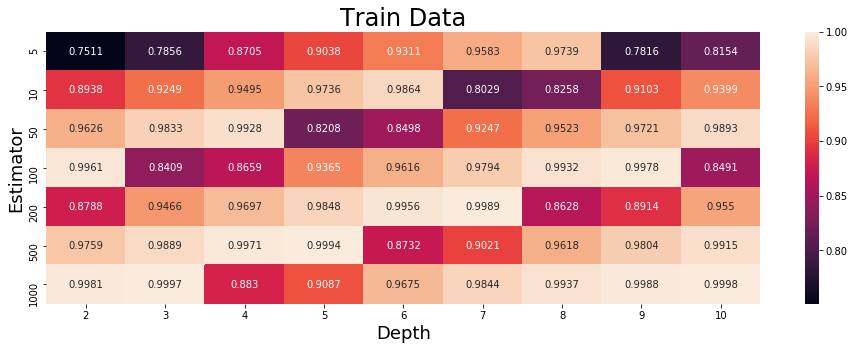

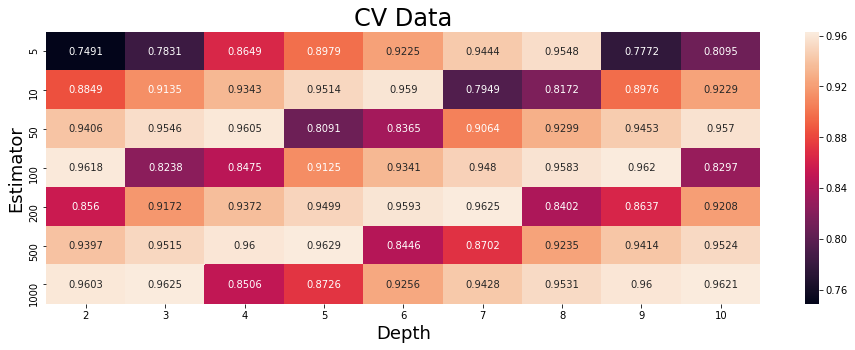

Max depth is =  8  Optimal value of n_estimator : 1000
--------------------------
Cv auc scores
[0.74914149 0.7830688  0.86485556 0.89790366 0.92252777 0.9443861
 0.95479245 0.77723378 0.80951478 0.884903   0.91350624 0.93426017
 0.9514343  0.95904899 0.79492082 0.81721252 0.89758297 0.92292511
 0.94056923 0.95460713 0.96048966 0.80908878 0.83646742 0.90638374
 0.92992244 0.94529508 0.95704848 0.96176269 0.82380639 0.84748675
 0.91246971 0.93405202 0.94799141 0.95831851 0.96204906 0.82973071
 0.85596184 0.91718078 0.93718239 0.94986793 0.95928038 0.96250128
 0.8401927  0.86367639 0.92079853 0.93971481 0.95149249 0.9600427
 0.96285202 0.84460868 0.8702411  0.92351061 0.94144369 0.95242703
 0.9603494  0.96253145 0.85058452 0.87259139 0.92563107 0.94281789
 0.95306491 0.95996007 0.96212908]
Maximun Auc value : 0.9628520199855344


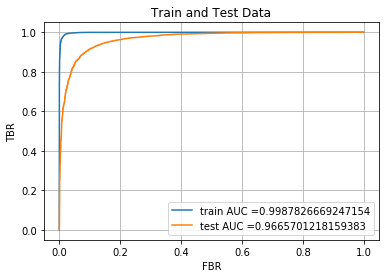

Train confusion matrix
[[ 6773   470]
 [   58 37589]]
Test confusion matrix
[[ 3660  1466]
 [  596 27278]]


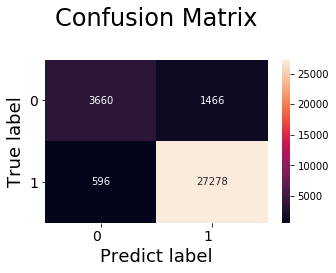

In [57]:
all_xg(X_train_bow,y_train,X_cv_bow)

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed: 101.0min finished


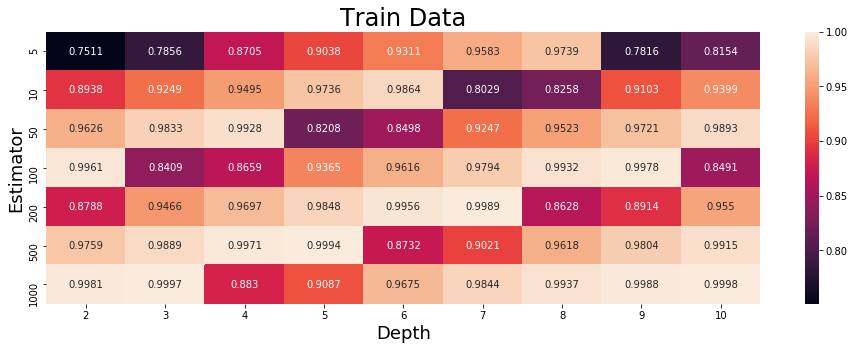

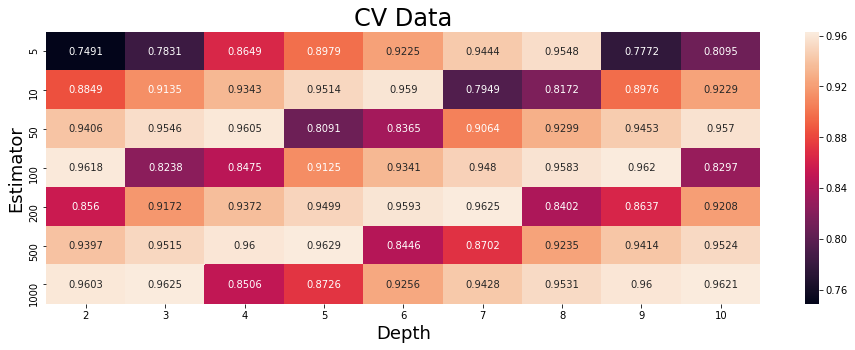

Max depth is =  8  Optimal value of n_estimator : 1000
--------------------------
Cv auc scores
[0.74914149 0.7830688  0.86485556 0.89790366 0.92252777 0.9443861
 0.95479245 0.77723378 0.80951478 0.884903   0.91350624 0.93426017
 0.9514343  0.95904899 0.79492082 0.81721252 0.89758297 0.92292511
 0.94056923 0.95460713 0.96048966 0.80908878 0.83646742 0.90638374
 0.92992244 0.94529508 0.95704848 0.96176269 0.82380639 0.84748675
 0.91246971 0.93405202 0.94799141 0.95831851 0.96204906 0.82973071
 0.85596184 0.91718078 0.93718239 0.94986793 0.95928038 0.96250128
 0.8401927  0.86367639 0.92079853 0.93971481 0.95149249 0.9600427
 0.96285202 0.84460868 0.8702411  0.92351061 0.94144369 0.95242703
 0.9603494  0.96253145 0.85058452 0.87259139 0.92563107 0.94281789
 0.95306491 0.95996007 0.96212908]
Maximun Auc value : 0.9628520199855344


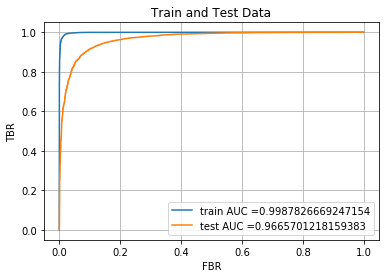

Train confusion matrix
[[ 6773   470]
 [   58 37589]]
Test confusion matrix
[[ 3660  1466]
 [  596 27278]]


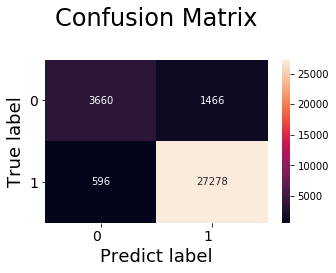

In [58]:
# Please write all the code with proper documentation
all_xg(X_train_tfidf,y_train,X_cv_tfidf)

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed: 93.7min finished


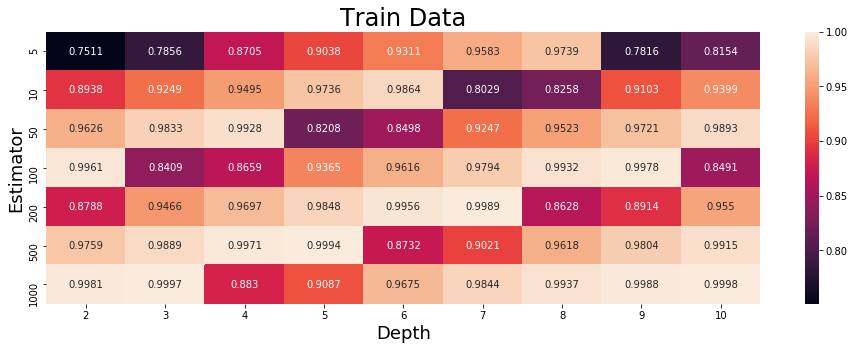

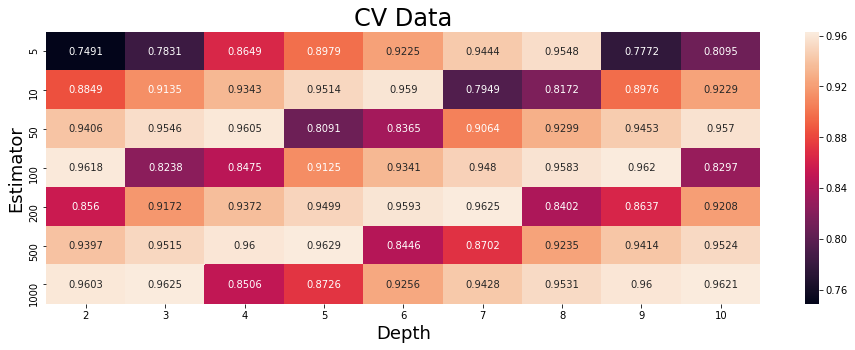

Max depth is =  8  Optimal value of n_estimator : 1000
--------------------------
Cv auc scores
[0.74914149 0.7830688  0.86485556 0.89790366 0.92252777 0.9443861
 0.95479245 0.77723378 0.80951478 0.884903   0.91350624 0.93426017
 0.9514343  0.95904899 0.79492082 0.81721252 0.89758297 0.92292511
 0.94056923 0.95460713 0.96048966 0.80908878 0.83646742 0.90638374
 0.92992244 0.94529508 0.95704848 0.96176269 0.82380639 0.84748675
 0.91246971 0.93405202 0.94799141 0.95831851 0.96204906 0.82973071
 0.85596184 0.91718078 0.93718239 0.94986793 0.95928038 0.96250128
 0.8401927  0.86367639 0.92079853 0.93971481 0.95149249 0.9600427
 0.96285202 0.84460868 0.8702411  0.92351061 0.94144369 0.95242703
 0.9603494  0.96253145 0.85058452 0.87259139 0.92563107 0.94281789
 0.95306491 0.95996007 0.96212908]
Maximun Auc value : 0.9628520199855344


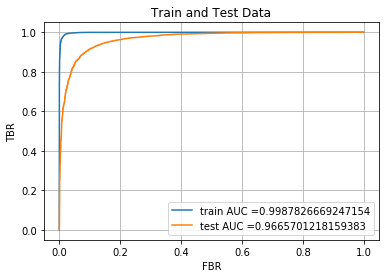

Train confusion matrix
[[ 6773   470]
 [   58 37589]]
Test confusion matrix
[[ 3660  1466]
 [  596 27278]]


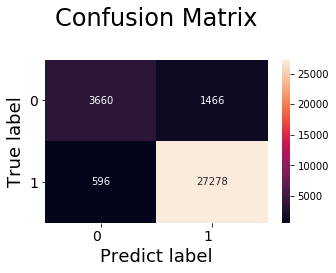

In [59]:
# Please write all the code with proper documentation
all_xg(train_vectors, y_train, X_cv)

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed: 85.9min finished


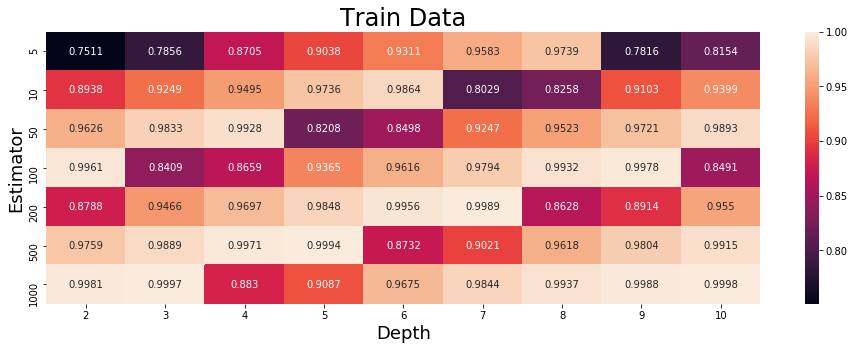

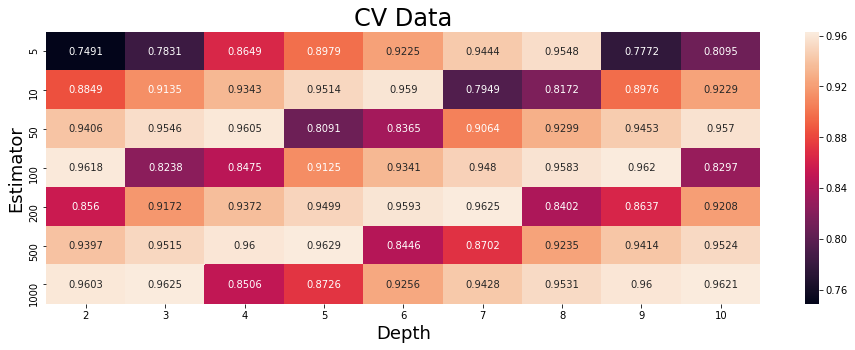

Max depth is =  8  Optimal value of n_estimator : 1000
--------------------------
Cv auc scores
[0.74914149 0.7830688  0.86485556 0.89790366 0.92252777 0.9443861
 0.95479245 0.77723378 0.80951478 0.884903   0.91350624 0.93426017
 0.9514343  0.95904899 0.79492082 0.81721252 0.89758297 0.92292511
 0.94056923 0.95460713 0.96048966 0.80908878 0.83646742 0.90638374
 0.92992244 0.94529508 0.95704848 0.96176269 0.82380639 0.84748675
 0.91246971 0.93405202 0.94799141 0.95831851 0.96204906 0.82973071
 0.85596184 0.91718078 0.93718239 0.94986793 0.95928038 0.96250128
 0.8401927  0.86367639 0.92079853 0.93971481 0.95149249 0.9600427
 0.96285202 0.84460868 0.8702411  0.92351061 0.94144369 0.95242703
 0.9603494  0.96253145 0.85058452 0.87259139 0.92563107 0.94281789
 0.95306491 0.95996007 0.96212908]
Maximun Auc value : 0.9628520199855344


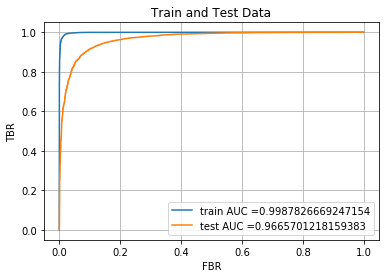

Train confusion matrix
[[ 6773   470]
 [   58 37589]]
Test confusion matrix
[[ 3660  1466]
 [  596 27278]]


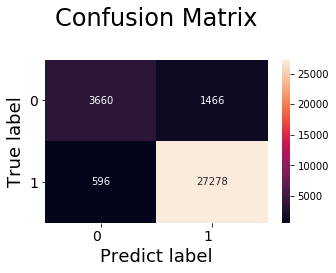

In [60]:
# Please write all the code with proper documentation
all_xg(tfidf_train_vectors,y_train,X_cv)

# [6] Conclusions

In [96]:
from prettytable import PrettyTable

 
Vectorizer = ['Bag of Words','TFIDF','AVG W2V','TFIDF W2V','Bag of Words','TFIDF','AVG W2V','TFIDF W2V']
Models = ['Random Forest','Random Forest','Random Forest','Random Forest','XGBOOST','XGBOOST','XGBOOST','XGBOOST']

max_depth=[10, 10,10, 10,8, 8,8, 8]

estimator =[500, 1000,1000, 1000,1000, 1000,1000, 1000]

auc =[0.93,0.93,0.93,0.93,0.96,0.96,0.96,0.96]
 
numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering) 
ptable.add_column("Vectorizer",Vectorizer)
ptable.add_column("Model",Models) 
ptable.add_column("Max Depth",max_depth)
ptable.add_column("Estimator",estimator)
ptable.add_column("AUC",auc)
 

print(ptable)

+-------+--------------+---------------+-----------+-----------+------+
| S.NO. |  Vectorizer  |     Model     | Max Depth | Estimator | AUC  |
+-------+--------------+---------------+-----------+-----------+------+
|   1   | Bag of Words | Random Forest |     10    |    500    | 0.93 |
|   2   |    TFIDF     | Random Forest |     10    |    1000   | 0.93 |
|   3   |   AVG W2V    | Random Forest |     10    |    1000   | 0.93 |
|   4   |  TFIDF W2V   | Random Forest |     10    |    1000   | 0.93 |
|   5   | Bag of Words |    XGBOOST    |     8     |    1000   | 0.96 |
|   6   |    TFIDF     |    XGBOOST    |     8     |    1000   | 0.96 |
|   7   |   AVG W2V    |    XGBOOST    |     8     |    1000   | 0.96 |
|   8   |  TFIDF W2V   |    XGBOOST    |     8     |    1000   | 0.96 |
+-------+--------------+---------------+-----------+-----------+------+


### Observed:
-When Apply XGBOOST is not fast as some other models we have seen before or applied before in this same data set, it takes more run time. 

-All 'Bow','TFIDF','AVG W2V','TFIDF W2V' for RF got 93% AUC values and XGBOOSTs 96%.